In [3]:
import os
import sys

sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
import orbithunter as orb
import numpy as np
import itertools
from math import pi
import time
import matplotlib.pyplot as plt
import h5py

def critical_values(scores):
    cval = [0.0001, 0.001, 0.01, 0.05]
    return np.array([np.quantile(scores, q) for q in cval])

def produce_scores(family, bases, **kwargs):
    # Make it so group orbit must be passed, not calculated here. 
    family_scores = None
    print('[', end='')
    n = 0 
    n_samples = len(family)*len(bases)
    for window in family:
        print('#', end='')
        window = window.transform(to='field')
        for base in bases:
            scr = scan(base, window, **kwargs)[0].ravel()
            if family_scores is None:
                family_scores = np.zeros([n_samples, len(scr)])                             
            family_scores[n, :] = np.array(scr).ravel()
            n+=1
    print(']',end='')
    return family_scores.reshape(len(family), -1)

# Shadowing and data exploration  

This notebook produces statistics on the shadowing and covering of space-time by fundamental orbits.
The steps are as follows

    1. Import and explore the orbit families produced by continuation. 
    2. Determine whether the continuations are single families or branches from multiple families. 
    3. Using these families in conjunction with integrated trajectories produce preliminary distributions of metric values.
    4. Create and save different subsets of families .
    4. Using this knowledge, produce more thorough distributions and statistics in a different notebook. 

In [5]:
large_patch_names = [str(i)+'/' for i in range(1001)][::10]
large_patch_samples = orb.read_h5('./data/large_patches.h5', large_patch_names).resize(832, 832).transform(to='field')

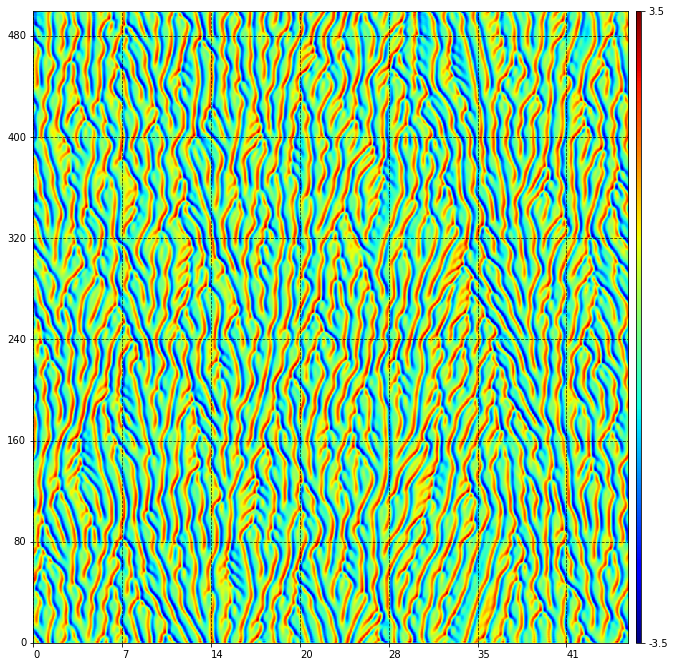

In [4]:
covering = [sorted([x.transform(to='field') for x in family], key=lambda o:o.x) for family in orb.read_h5('./data/continuation.h5')]
base = orb.read_h5('./data/large_patches.h5', '/1').resize(832, 832).transform(to='field')
base.plot()

# Shadowing

Before we can talk about the statistics and proportion of space-time that each orbit family covers,
we must first determine the baselines/threshold values for the shadowing metric. The most important
reason is simply to get a threshold value which is non-arbitary, based upon the distribution of this metric when
ranging over families, group orbits, and arbitrary trajectory segments in space-time. The second reason is to
delve into the details of the families themselves. As we shall see, not every orbit reached by numerical continuation is necessarily in the same continuous family. If accidentally mixed, then the thresholds as determined by the
distributions of the shadowing metric likely do not make sense. Persistent homology is used towards this end. It provides a guide for how to determine both the sampling and bounds of the members of each family to be used
as our covering set.

## Single family investigation

As an example let us first investigate a single family and determine if it is indeed a "single" family. Import orbits and
sort by the temporal period (continuation parameter).

In [3]:
defect_family = covering[0]
family_size = [len(x) for x in covering]

defect_family = sorted(covering[0], key=lambda x : x.t)
drifter_family = sorted(covering[1], key=lambda x : x.t)
large_defect_family = sorted(covering[2], key=lambda x : x.t)
wiggle_family = sorted(covering[3], key=lambda x : x.t)

One of the assumptions is that each orbit manifests on tiles of unique size. Let us plot the parameters for each of the family members, parameterized by the continuation parameter. 

The highlighted point simply indicates the possible branch cut.

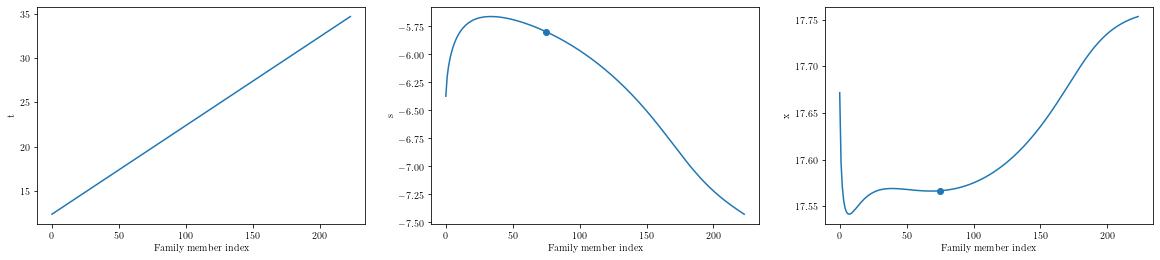

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
ax1.plot([x.t for x in large_defect_family])
ax2.plot([x.s for x in large_defect_family])
ax2.scatter([75], [large_defect_family[75].s])
ax3.plot([x.x for x in large_defect_family])
ax3.scatter([75], [large_defect_family[75].x])

ax1.set_xlabel('Family member index')
ax2.set_xlabel('Family member index')
ax3.set_xlabel('Family member index')

ax1.set_ylabel('t')
ax2.set_ylabel('s')
ax3.set_ylabel('x') 
plt.show()

The fact that multiple orbits exist at the same spatial domain size destroys the uniqueness we want. There is still hope, however, if these actually pertain to different families. These branches can then be pruned or separated, but we need some type of quantitative, objective metric to decide this for us. I use persistent homology, specifically, the bottleneck distances between all pairs of family members are computed, using a periodic cubical complex.

In [5]:
all_persistences = []
for each_orbit in large_defect_family:
    all_persistences.append(ohgudhi.orbit_complex(each_orbit,
                                                 ).persistence())
entirety_homology_large_defect_scores = np.zeros([len(all_persistences),len(all_persistences)])
for i in range(len(all_persistences)):
    for j in range(i, len(all_persistences)):
        entirety_homology_large_defect_scores[i, j] = ohgudhi.gudhi_distance_from_persistence(all_persistences[i], 
                                                                                 all_persistences[j],
                                                                                 metric='bottleneck')
        
homology_large_defect_scores = entirety_homology_large_defect_scores.reshape(len(all_persistences),len(all_persistences))
maxscore_before_pruning = homology_large_defect_scores.max()
maxscore_after_pruning = homology_large_defect_scores[75:, 75:].max()
homology_large_defect_scores[homology_large_defect_scores==0.]=np.nan

In [6]:
print('The maximum bottleneck distance before pruning in {}'.format(maxscore_before_pruning))

The maximum bottleneck distance before pruning in 0.832016311738579


Prior to any pruning or separation of continuation members, the bottleneck distance between pairs of members can be visualized by the following matrix plot. The matrix elements $M_{ij}$ correspond to the bottleneck distance between the $i$th and $j$th orbits. The matrix is symmetric and so only the upper triangular portion is plotted here. As can be seen, the members with small indices are further in bottleneck distance, meaning they are dissimilar, to the orbits with larger index. (Index here being a discrete label for the temporal continuation, technically). Fortunate for us, this is exactly the partition that explains the lack of unique tiles. 

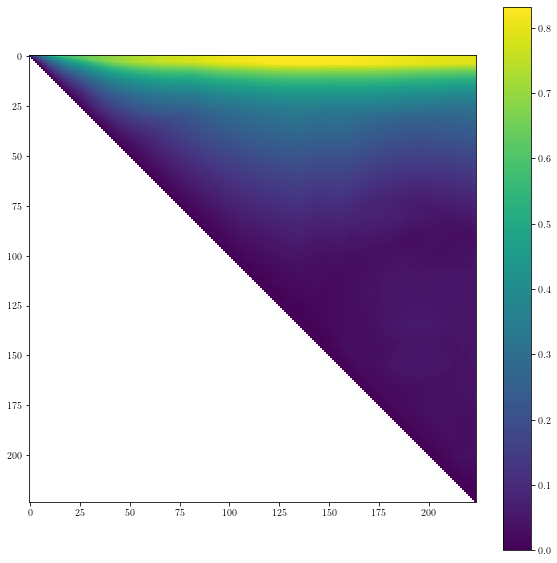

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(homology_large_defect_scores, interpolation='none')
plt.colorbar()
plt.show()

The claim is that this metric can be used to partition the continuation members into two branches; luckily this partition corresponds to the monotonicity we desired earlier. For comparison purposes, the density plot is plotted with the same scale as for the full continuation.

The maximum bottleneck distance after pruning in 0.1165519334039089


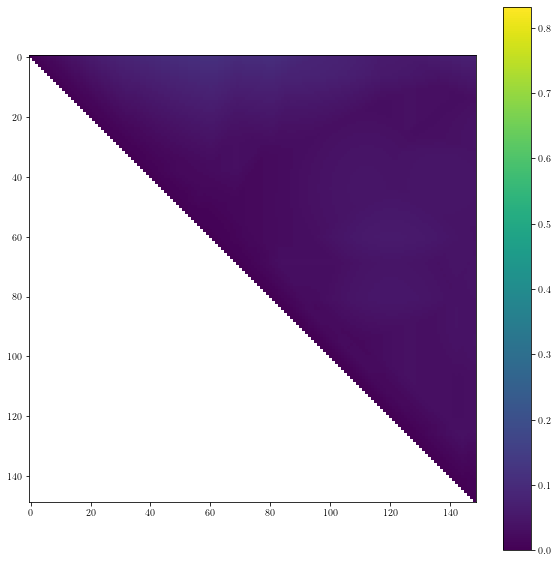

In [8]:
print('The maximum bottleneck distance after pruning in {}'.format(maxscore_after_pruning))

plt.figure(figsize=(10,10))
plt.imshow(homology_large_defect_scores[75:, 75:], interpolation='none',
           vmin=0., vmax=maxscore_before_pruning)
plt.colorbar()
plt.show()

Following partitions of this format, the following plots demonstrate the ranges of parameter values for each family.

#### Defect family parameter plots

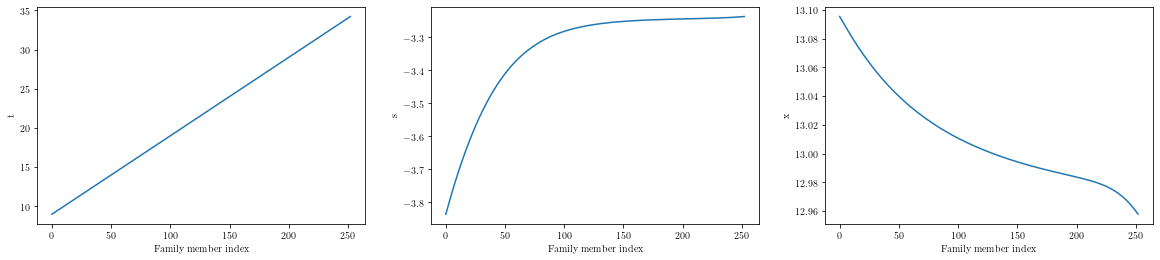

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
ax1.plot([x.t for x in defect_family[10:]])
ax2.plot([x.s for x in defect_family[10:]])
ax3.plot([x.x for x in defect_family[10:]])
ax1.set_xlabel('Family member index')
ax2.set_xlabel('Family member index')
ax3.set_xlabel('Family member index')
ax1.set_ylabel('t')
ax2.set_ylabel('s')
ax3.set_ylabel('x') 
plt.show()

#### "Large defect" family parameter plots.
"Large defect" is believed to be (due to bottleneck distance) the defect family branch at large spatial domains, $L\approx 17$. The continuation seems unable to track the defect family on the interval $\approx(13.2, 17)$, as only relative equilibria are found.

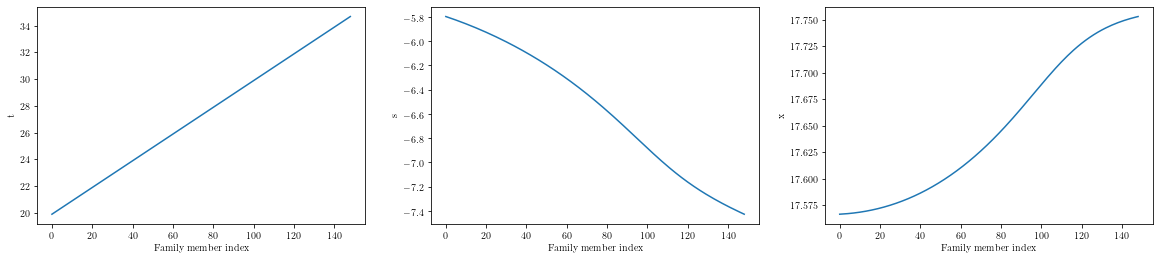

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
ax1.plot([x.t for x in large_defect_family[75:]])
ax2.plot([x.s for x in large_defect_family[75:]])
ax3.plot([x.x for x in large_defect_family[75:]])
ax1.set_xlabel('Family member index')
ax2.set_xlabel('Family member index')
ax3.set_xlabel('Family member index')
ax1.set_ylabel('t')
ax2.set_ylabel('s')
ax3.set_ylabel('x') 
plt.show()

#### "Wiggle" family. 
Because the smaller spatial domain wiggle approaches the streak, the streak itself is not used, as the lack of time scale
makes deciding upon a discretization size tricky. The idea I have is to compute the coverings and then claim everything else is a streak.

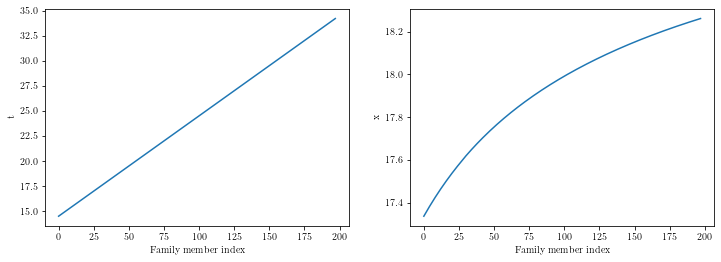

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot([x.t for x in wiggle_family[65:]])
ax2.plot([x.x for x in wiggle_family[65:]])
ax1.set_xlabel('Family member index')
ax2.set_xlabel('Family member index')
ax1.set_ylabel('t')
ax2.set_ylabel('x') 
plt.show()

In [12]:
# Update the families with pruning
defect_family = sorted(covering[0], key=lambda x : x.t)[10:]
drifter_family = sorted(covering[1], key=lambda x : x.t)
large_defect_family = sorted(covering[2], key=lambda x : x.t)[75:]
wiggle_family = sorted(covering[3], key=lambda x : x.t)[65:]

covering_families = [defect_family, drifter_family, large_defect_family, wiggle_family]
entire_covering = [o for fam in covering_families for o in fam]

### Methodology

To collect our distribution of the amplitude difference metric, there are three choices to be made.

    1. The base orbits to scan over
    2. How often to sample them (i.e. how many window positions to compute the amplitude difference).
    3. How many group orbit members to use for each window orbit.
    
For the preliminary investigations, thirty different trajectory segments produced by integration are used, each of which has large spatiotemporal area. To reduce their relations to one another, the trajectory segments are part of a very long trajectory which has been chopped into pieces. Every other piece is collected to be used as a base orbit. Clearly if regions of space-time can be strongly correlated when separated by 500 dimensionless time units, this breaks down.

Instead of exhaustively computing the statistic; for every position for each group orbit member in each family, the
sampling is done by taking a subset of the group orbit members and a subset of the positions; for each member of the
continuous family defined in ```defect_family```

In [14]:
sampling_rate = 1
bases_labels = [str(int(base_num*sampling_rate))for base_num in range(1000)]
bases = [y for y in  read_h5('small_patches.h5', tuple(bases_labels))]

To compute the amplitude differences, iterate over the windows (family members), each window's group orbit (taken to be discrete subgroup for this run, and the 30 base orbits (trajectories). 

#### Group orbit distribution of amplitude difference $|u^2 - v^2|$ metric

In [15]:
kwargs = {          
          'strides': (64, 64),
          'fundamental_domain': False,
          'group_orbit': False,
           }

defect_family_scores = produce_scores([x for x in defect_family[::5]], bases[::2], **kwargs)

[###################################################]

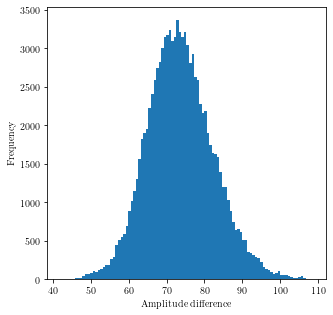

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.hist(defect_family_scores.ravel(), bins=100)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Amplitude difference')
plt.show()

The distribution for each family member (all group orbit members included) can be overlaid on top of one another to approximate whether the variables can be treated as IID or not. 



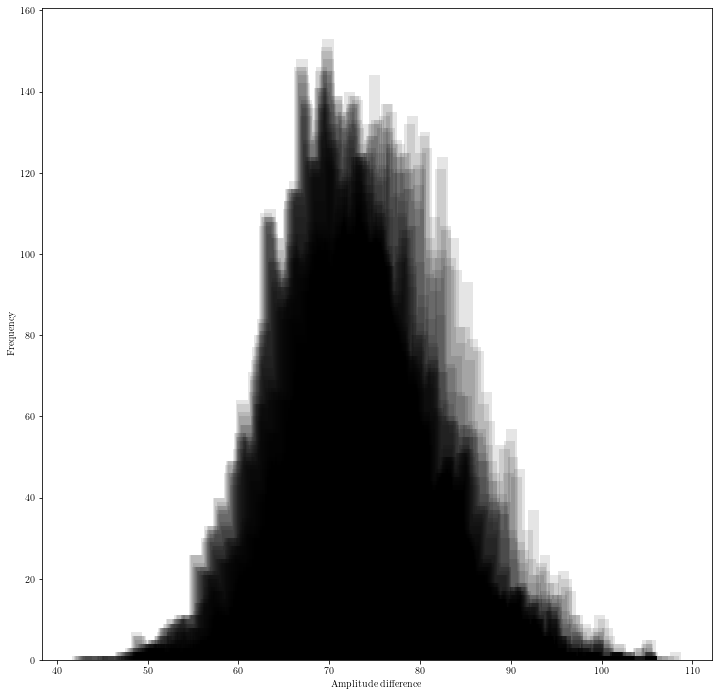

In [17]:
plt.figure(figsize=(12,12))
for g in defect_family_scores.reshape(len(defect_family[::5]), -1):
    plt.hist(g.ravel(), alpha=0.1, color='black', bins=50)
plt.ylabel('Frequency')
plt.xlabel('Amplitude difference')
plt.show()

In [18]:
kwargs = {          
          'strides': (64, 64),
          'fundamental_domain': False,
           }
group_orbit = tuple(defect_family[-200].group_orbit(rolls=(8,8)))
defect_group_orbit_scores = produce_scores(group_orbit, bases[::2], **kwargs)

[################################]

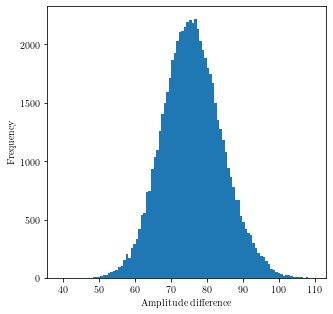

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.hist(defect_group_orbit_scores.ravel(), bins=100)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Amplitude difference')
plt.show()

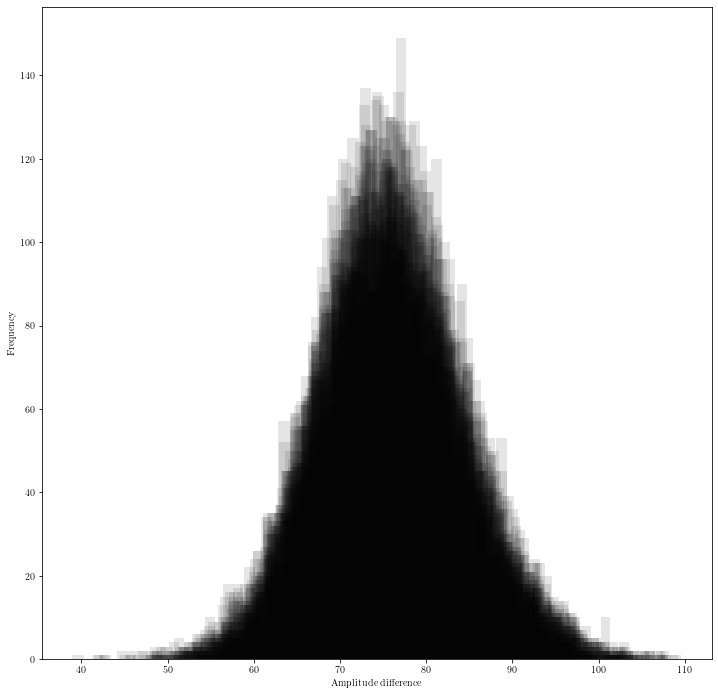

In [20]:
plt.figure(figsize=(12,12))
for g in defect_group_orbit_scores.reshape(len(tuple(defect_family[-200].group_orbit(rolls=(8,8)))),-1):
    plt.hist(g.ravel(), alpha=0.1, color='black', bins=50)
plt.ylabel('Frequency')
plt.xlabel('Amplitude difference')
plt.show()

Because we want thresholds for each family, it does not make sense to me to use a single threshold value if each
member has a different distribution. To determine the bounds of each family, I appeal to persistent homology;
specifically, the "bottleneck distance" between the family members. This is made accessible through the ```gudhi``` package, which I have built in some wrappers for.

In [21]:
import orbithunter.persistent_homology as ohgudhi

Take the pairwise bottleneck distance between each family member and plot as as a symmetric matrix

#### Family partitionion based on persistent homology.

To really hammer the point home: even though we basically know how to split orbits up into families, based on the original continuation, compute ALL pointwise bottleneck distances between all families.

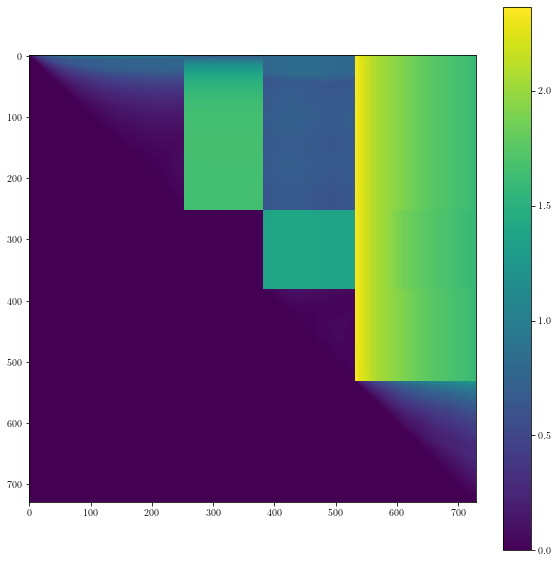

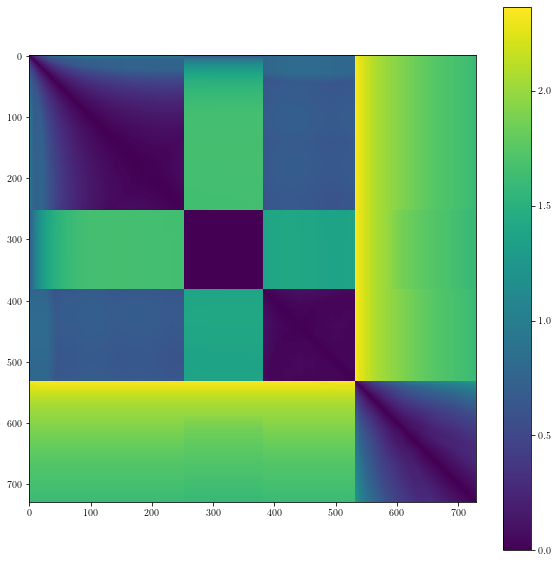

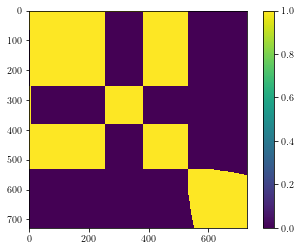

In [22]:
all_persistences = []
for each_orbit in entire_covering:
    all_persistences.append(ohgudhi.orbit_complex(each_orbit,
                                                 ).persistence(min_persistence=0.01))
entirety_homology_scores = np.zeros([len(all_persistences),len(all_persistences)])
for i in range(len(all_persistences)):
    for j in range(i, len(all_persistences)):
        entirety_homology_scores[i, j] = ohgudhi.gudhi_distance_from_persistence(all_persistences[i], 
                                                                                 all_persistences[j],
                                                                                 metric='bottleneck')
        
homology_scores = entirety_homology_scores.reshape(len(all_persistences),len(all_persistences))

plt.figure(figsize=(10,10))
plt.imshow(homology_scores, interpolation='none')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow((entirety_homology_scores+entirety_homology_scores.T), interpolation='none')
plt.colorbar()
plt.show()

plt.imshow(((entirety_homology_scores+entirety_homology_scores.T) < 0.9).astype(int), interpolation='none')
plt.colorbar()
plt.show()

Why is there coupling (the checkerboard pattern) instead of a block diagonal structure? (this used an arbitrary threshold mind you). It turns out that the first three "families" are likely connected, but the second family is topologically distinct from the first and third families, as it is a relative equilibrium and not a relative periodic orbit. The checkerboard pattern simply emerges from their arrangement. To provide evidence for this we can look at the 'families' members directly. For example. The first 5 or so members of the first family can be compared to the third family.

(32.31084483219184, 12.973721398833037)


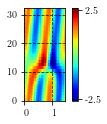

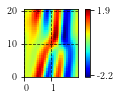

(31.310844832191798, 12.978045930356435)


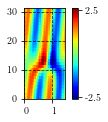

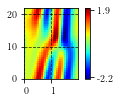

(30.31084483219164, 12.980951030532486)


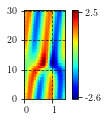

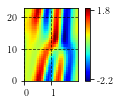

In [23]:
for x,y  in zip(np.array(defect_family)[[-20, -30, -40]], np.array(large_defect_family)[[10, 20, 30]]):
    print(x.dimensions())
    x.plot(), y.plot()

Split up the families using the bottleneck distance values; essentially imposing a block diagonal structure on the bottleneck
matrix.

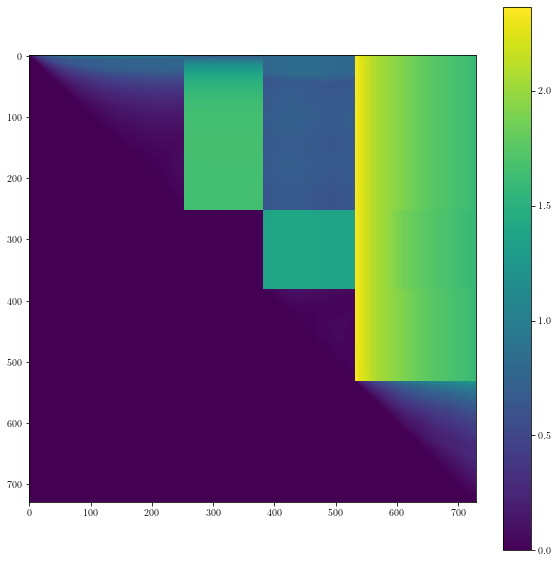

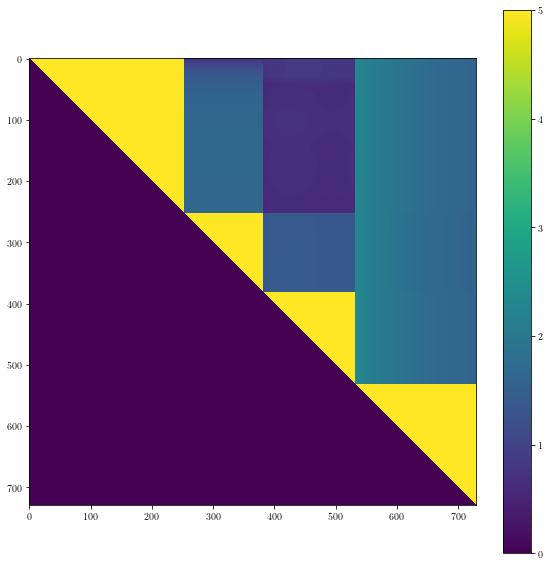

In [24]:
truth_values = homology_scores.copy()
plt.figure(figsize=(10,10))
plt.imshow(homology_scores, interpolation='none')
plt.colorbar()
plt.show()

for slc in [slice(0,253), slice(253, 382), slice(382, 531), slice(531,None)]:
    truth_values[slc, slc] = 5
truth_values=truth_values.T
truth_values[np.triu_indices(truth_values.shape[0], k=0)]=0
truth_values=truth_values.T

plt.figure(figsize=(10,10))
plt.imshow(truth_values, interpolation='none')
plt.colorbar()
plt.show()

Let's look at the constituents of each family in this partitioning; all orbits in a single family should be similar to the others.

################################################


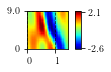

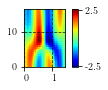

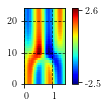

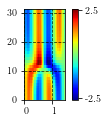

################################################


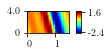

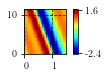

################################################


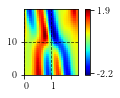

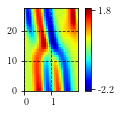

################################################


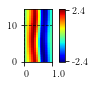

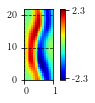

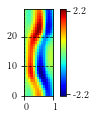

In [25]:
for slc in [slice(0,253), slice(253, 382), slice(382, 531), slice(531,None)]:
    print('################################################')
    for orbit in entire_covering[slc][::75]:
        orbit.to_fundamental_domain().plot(padding=False)

In [26]:
covering_processed = []
for slc in [slice(0,253), slice(253, 382), slice(382, 531), slice(531,None)]:
    covering_processed.append(entire_covering[slc])
large_covering = [np.array(x) for x in covering_processed]

Save covers of different sizes for testing purposes.

###
(14.30084483218944, 13.03759136983164, -3.398712699303085)


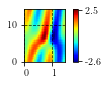

###
(14.419717642897997, 13.174810274046457, -6.732012555306101)


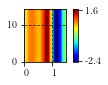

###
(22.390629775248556, 17.57516682770209, -5.965036160383544)


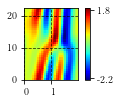

###
(15.000880409356625, 17.39252506361242, 0.0)


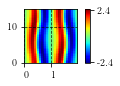

In [27]:
# for slicing purposes
large_covering = [np.array(x) for x in covering_processed]

medium_covering =[np.array(large_covering[0])[100::25],
                                           np.array(large_covering[1])[::25],
                                           np.array(large_covering[2])[:-50:25],
                                           np.array(large_covering[3])[::25]]

small_covering = [np.array(large_covering[0])[100::50],
                                           np.array(large_covering[1])[::50],
                                           np.array(large_covering[2])[:-50:50],
                                           np.array(large_covering[3])[::50]]

minimal_covering = [np.array(large_covering[0])[[-200]],
         np.array(large_covering[1])[[-25]],
         np.array(large_covering[2])[[25]],
         np.array(large_covering[3])[[5]]]

for x in minimal_covering:
    print('###')
    for y in x:
        print(y.parameters)
        y.plot()

In [30]:
# for name, families in zip(keys, covering_processed):
#     for orbit in families:
#         orbit.to_h5('large_cover.h5', groupname=name, verbose=True)

# for name, families in zip(keys, medium_covering):
#     for orbit in families:
#         orbit.to_h5('medium_cover.h5', groupname=name, verbose=True)

# for name, families in zip(keys, small_covering):
#     for orbit in families:
#         orbit.to_h5('small_cover.h5', groupname=name, verbose=True)

# for name, families in zip(keys, minimal_covering):
#     for orbit in families:
#         orbit.to_h5('minimal_cover.h5', groupname=name, verbose=True)